<a href="https://colab.research.google.com/github/tihana-britvic-sb/first_streamlit_app/blob/main/CausalImpact_with_google_sheets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  [Causal Impact] Python Colab with Google Sheets

Causal Impact can be used to estimate the impact an event has on a key performance indicator (KPI) using synthetic control groups that are correlated to the KPI but not impacted by the event.

This Colab runs a Causal Impact analysis using a Google Sheet for inputs.

## Steps for Running
* Define KPI to measure
* Choose control groups that are correlated but not impacted.
* Collect + populate the data.
* Run the analysis.
* Understand the output.

## Picking Control Groups

* Unaffected predictors: The covariates (control) are unaffected by the intervention.
* Stable relationship: The relationship between the covariates (control) and the outcome variable (response) would have remained stable under no treatment.

If the target KPI can be split by location then the markets where the event isn't used can be used as control groups. For example conversions in UK around an Diwali related advert is run can be compared to conversions in France where the advert wasn't run. Even though the control group is the same as the KPI it can't be used as a covariate as it isn't impacted by the advert.

Control groups should be related to the outcome but not changed by the event. To check the incrementallity effect on conversions from a branded campaign on YouTube the covariates to use could be clicks, sessions, new users from site analytics.


## Use Cases For Causal Impact
* Check the impact of a branding campaign.
* Validate account restucturing on campaigns.
* Measure the impact of a drop in spend.
* Prove the incremental value of running additional campaign types.
* Post analysis of an unplanned event.

## More Information
Visit the [tfp-causalimpact](https://github.com/google/tfp-causalimpact) library on GitHub for more details on the implementation and algorithm.

See also `Inferring causal impact using Bayesian structural time-series models.` Kay H. Brodersen, Fabian Gallusser, Jim Koehler, Nicolas Remy, Steven L. Scott. Annals of Applied Statistics, vol. 9 (2015), pp. 247-274. https://research.google/pubs/pub41854/




## Google Sheet Template Configuration

Make a copy of this Google Sheet and use the copy in the input below
 https://docs.google.com/spreadsheets/d/1VgA7uMxYF6tsnBwgJqpj4oaLAqYPQlb8pBI0VIDGel4/edit#gid=0


### Valid Formatting

 * Apart from the first column the headings can be changed.
 * The first column is the date of the observation and must be named `date`.
     * The date format must be YYYY-MM-DD.
     * In this Colab the dates are daily values. Not weekly.
     * Order the rows chronologically from oldest to newest.
 * The second column is the key performance indicator (KPI) to analyse.
 * The third column and after are covariates aka control groups.
 * Replace or estimate empty or null values.
 * Numbers must be in the format 1234.56. If there are commas, it will not convert properly (e.g. 1,234.56)


In [ ]:
!pip install tfp-causalimpact itables
import pandas as pd
import numpy as np
import causalimpact
from IPython.display import display, Markdown
from itables import show

## Configure The Analysis

In [ ]:
# Google Sheet for data streams
google_sheets_url = 'https://docs.google.com/spreadsheets/d/1a3kdyZmemrmF0-uZxLp08-LXS-c8ZP4Mi8oLnwWjQOU/edit?gid=0#gid=0'#@param

#date of event
event_date = '2019-10-07'#@param {type:"date"}

#How many days before intervention will be analyzed
days_before_event = 90#@param {type:"number"}

#how many days post intervention wou want to analyze (including the event date)
days_after_event = 7#@param {type:"number"}

#Number of series used as counterfactuals (0 to many, each in a column of the sheet)
number_of_covariates = 4#@param {type:"number"}



#convert input to DateTime
event_date = pd.to_datetime(event_date, format='%Y-%m-%d', errors='ignore')

print("Causal Impact version: ", causalimpact.__version__)

Causal Impact version:  0.2.6


<ipython-input-8-c95648c44d3d>:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  event_date = pd.to_datetime(event_date, format='%Y-%m-%d', errors='ignore')


## Load Data From Google Sheets

<ipython-input-5-e2fa007d83e5>:27: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
<ipython-input-5-e2fa007d83e5>:30: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.date = pd.to_datetime(df.date, format='%Y-%m-%d', errors='ignore')


###Explore the imported data

###Validate everything has a value

If any of the values are False there is missing data in that column.

,0
0,
date,True
target,True
average_time_on_site,True
pageviews,True
bounces,True
hits,True


###Visually compare the covariates

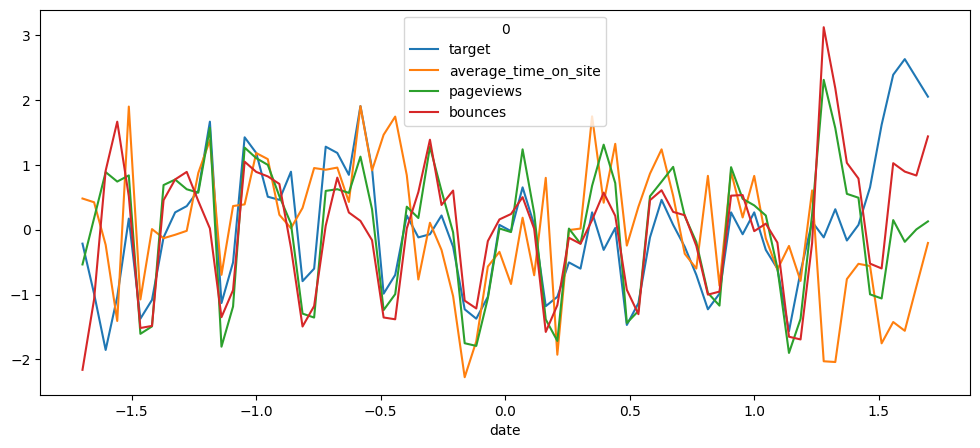

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open_by_url(google_sheets_url).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df = pd.DataFrame.from_records(rows)

#get column names from first row
df.columns = df.iloc[0]

#drop row with column names
df = df.drop(df.index[0])

#reset indexes
df = df.reset_index(drop=True)

#convert numeric data to numeric types
df = df.apply(pd.to_numeric, errors='ignore')

#convert dates to dates type
df.date = pd.to_datetime(df.date, format='%Y-%m-%d', errors='ignore')



assert event_date in df.date.values, f"The Google Sheet doesn't contain the input date: \"{event_date.date()}\"."

event_index = df.loc[df.date==event_date].index[0]-1;

#explore data
display(Markdown("###Explore the imported data"))
show(df);

display(Markdown("###Validate everything has a value"))
display(Markdown("If any of the values are False there is missing data in that column."))
display(df.notnull().all())


display(Markdown("###Visually compare the covariates"))
normalized_df = df.iloc[:,0:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
normalized_df.plot(x='date', figsize=(12, 5));


## Optional Input Validation

In [ ]:
display(df.corr(method='pearson', numeric_only=False))

df.describe()

,date,target,average_time_on_site,pageviews,bounces,hits
0,,,,,,
date,1.000000,0.191904,-0.337174,-0.048980,0.167392,-0.119436
target,0.191904,1.000000,0.133516,0.524606,0.513801,0.506460
average_time_on_site,-0.337174,0.133516,1.000000,0.257073,-0.122037,0.309502
pageviews,-0.048980,0.524606,0.257073,1.000000,0.846388,0.995364
bounces,0.167392,0.513801,-0.122037,0.846388,1.000000,0.812374
hits,-0.119436,0.506460,0.309502,0.995364,0.812374,1.000000


,date,target,average_time_on_site,pageviews,bounces,hits
count,74,74.000000,74.000000,74.000000,74.000000,74.000000
mean,2019-09-06 12:00:00,38.459459,280.358514,11303.486486,1193.878378,14131.864865
min,2019-08-01 00:00:00,0.000000,222.340000,6123.000000,728.000000,7399.000000
25%,2019-08-19 06:00:00,24.000000,263.130000,8587.750000,993.250000,10706.000000
50%,2019-09-06 12:00:00,37.000000,280.695000,11888.500000,1224.500000,14760.500000
75%,2019-09-24 18:00:00,48.000000,301.525000,13171.250000,1324.750000,16604.250000
max,2019-10-13 00:00:00,93.000000,328.940000,17601.000000,1867.000000,20967.000000
std,NaN,20.731942,25.496306,2725.028331,215.544799,3405.085835


## Run The Analysis

In [ ]:
pre_period = [int(max(0, event_index-days_before_event)), int(event_index)]
post_period = [int(event_index + 1), int(event_index + days_after_event)]

impact = causalimpact.fit_causalimpact(
    data=df[df.columns[1:number_of_covariates + 2]],
    pre_period=pre_period,
    post_period=post_period)

display(Markdown("##Summary report"))
print(causalimpact.summary(impact, output_format='summary'))

display(Markdown("##Plotted results"))
display(causalimpact.plot(impact, static_plot=False, chart_width=800))

display(Markdown("##Detailed Report"))
print(causalimpact.summary(impact, output_format='report'))


##Summary report


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    73.3               513.0
Prediction (s.d.)         26.1 (4.25)        182.9 (29.73)
95% CI                    [17.3, 34.3]       [121.1, 239.8]

Absolute effect (s.d.)    47.2 (4.25)        330.1 (29.73)
95% CI                    [39.0, 56.0]       [273.2, 391.9]

Relative effect (s.d.)    191.2% (52.7%)     191.2% (53.0%)
95% CI                    [114.0%, 323.6%]   [114.0%, 323.6%]

Posterior tail-area probability p: 0.001
Posterior prob. of a causal effect: 99.89%

For more details run the command: summary(impact, output_format="report")


/usr/local/lib/python3.10/dist-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


##Plotted results

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: Futu

alt.HConcatChart(...)

##Detailed Report


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 73.3. By contrast, in the absence of an
intervention, we would have expected an average response of 26.1.
The 95% interval of this counterfactual prediction is [17.3, 34.3].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 47.2 with a 95% interval of
[39.0, 56.0]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 513.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 182.9. The 95% interval of this prediction is [121.1, 239.8].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed 

/usr/local/lib/python3.10/dist-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


Create Shiny App

In [ ]:
!pip install itables shiny causalimpact gspread

In [ ]:
from shiny import App, ui, render
import pandas as pd
import numpy as np
import gspread
import causalimpact
from google.colab import auth
from google.auth import default

# Initialize authentication for Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Shiny UI
app_ui = ui.page_sidebar(
    ui.sidebar(
        ui.input_text("google_sheets_url", "Google Sheets URL", value=''),  # Empty box for Google Sheets URL input
        ui.input_date("event_date", "Event Date", value='2019-10-07'),
        ui.input_numeric("days_before_event", "Days Before Event", value=90),
        ui.input_numeric("days_after_event", "Days After Event", value=7),
        ui.input_numeric("number_of_covariates", "Number of Covariates", value=4),
        ui.input_action_button("run_analysis", "Run Analysis")
    ),
    ui.layout_columns(
        ui.column(6, ui.output_text("status")),
        ui.column(6, ui.output_plot("data_plot")),
        ui.column(6, ui.output_plot("impact_plot")),
        ui.column(6, ui.output_text("summary_report")),
        ui.column(6, ui.output_text("detailed_report"))
    )
)

# Server logic
def server(input, output, session):

    @output
    @render.text
    def status():
        return "App is running. Please input parameters and run the analysis."

    @output
    @render.plot
    def data_plot():
        google_sheets_url = input.google_sheets_url()
        if not google_sheets_url:
            return "Error: Please enter a valid Google Sheets URL."

        try:
            # Load data from Google Sheets
            worksheet = gc.open_by_url(google_sheets_url).sheet1
            rows = worksheet.get_all_values()
            df = pd.DataFrame.from_records(rows)
            df.columns = df.iloc[0]
            df = df.drop(df.index[0]).reset_index(drop=True)
            df = df.apply(pd.to_numeric, errors='ignore')
            df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='ignore')

            # Normalize data and plot
            normalized_df = df.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
            normalized_df['date'] = df['date']
            return normalized_df.plot(x='date', figsize=(12, 5))
        except Exception as e:
            return f"Error loading data from Google Sheets: {e}"

    @output
    @render.plot
    def impact_plot():
        google_sheets_url = input.google_sheets_url()
        if not google_sheets_url:
            return "Error: Please enter a valid Google Sheets URL."

        try:
            # Get parameters from input
            event_date = pd.to_datetime(input.event_date(), format='%Y-%m-%d')
            days_before_event = input.days_before_event()
            days_after_event = input.days_after_event()
            number_of_covariates = input.number_of_covariates()

            # Load data from Google Sheets
            worksheet = gc.open_by_url(google_sheets_url).sheet1
            rows = worksheet.get_all_values()
            df = pd.DataFrame.from_records(rows)
            df.columns = df.iloc[0]
            df = df.drop(df.index[0]).reset_index(drop=True)
            df = df.apply(pd.to_numeric, errors='ignore')
            df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='ignore')

            # Validate event date
            assert event_date in df['date'].values, f"The Google Sheet doesn't contain the input date: \"{event_date.date()}\"."
            event_index = df.loc[df['date'] == event_date].index[0]

            # Run the Causal Impact analysis
            pre_period = [int(max(0, event_index - days_before_event)), int(event_index)]
            post_period = [int(event_index + 1), int(event_index + days_after_event)]
            impact = causalimpact.CausalImpact(
                data=df[df.columns[1:number_of_covariates + 2]],
                pre_period=pre_period,
                post_period=post_period
            )

            # Plot the results
            return impact.plot()
        except Exception as e:
            return f"Error processing Causal Impact analysis: {e}"

    @output
    @render.text
    def summary_report():
        google_sheets_url = input.google_sheets_url()
        if not google_sheets_url:
            return "Error: Please enter a valid Google Sheets URL."

        try:
            # Reuse the data loading and processing code
            worksheet = gc.open_by_url(google_sheets_url).sheet1
            rows = worksheet.get_all_values()
            df = pd.DataFrame.from_records(rows)
            df.columns = df.iloc[0]
            df = df.drop(df.index[0]).reset_index(drop=True)
            df = df.apply(pd.to_numeric, errors='ignore')
            df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='ignore')

            # Get input parameters
            event_date = pd.to_datetime(input.event_date(), format='%Y-%m-%d')
            days_before_event = input.days_before_event()
            days_after_event = input.days_after_event()
            number_of_covariates = input.number_of_covariates()

            # Perform Causal Impact analysis
            event_index = df.loc[df['date'] == event_date].index[0]
            pre_period = [int(max(0, event_index - days_before_event)), int(event_index)]
            post_period = [int(event_index + 1), int(event_index + days_after_event)]
            impact = causalimpact.CausalImpact(
                data=df[df.columns[1:number_of_covariates + 2]],
                pre_period=pre_period,
                post_period=post_period
            )

            # Display the summary report
            return impact.summary(output_format='summary')
        except Exception as e:
            return f"Error generating summary report: {e}"

    @output
    @render.text
    def detailed_report():
        google_sheets_url = input.google_sheets_url()
        if not google_sheets_url:
            return "Error: Please enter a valid Google Sheets URL."

        try:
            # Reuse the data loading and processing code
            worksheet = gc.open_by_url(google_sheets_url).sheet1
            rows = worksheet.get_all_values()
            df = pd.DataFrame.from_records(rows)
            df.columns = df.iloc[0]
            df = df.drop(df.index[0]).reset_index(drop=True)
            df = df.apply(pd.to_numeric, errors='ignore')
            df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='ignore')

            # Get input parameters
            event_date = pd.to_datetime(input.event_date(), format='%Y-%m-%d')
            days_before_event = input.days_before_event()
            days_after_event = input.days_after_event()
            number_of_covariates = input.number_of_covariates()

            # Perform Causal Impact analysis
            event_index = df.loc[df['date'] == event_date].index[0]
            pre_period = [int(max(0, event_index - days_before_event)), int(event_index)]
            post_period = [int(event_index + 1), int(event_index + days_after_event)]
            impact = causalimpact.CausalImpact(
                data=df[df.columns[1:number_of_covariates + 2]],
                pre_period=pre_period,
                post_period=post_period
            )

            # Detailed report
            return impact.summary(output_format='report')
        except Exception as e:
            return f"Error generating detailed report: {e}"

# Create the app object
app = App(app_ui, server)

# Run the app
if __name__ == "__main__":
    import shiny
    shiny.run_app(app, host='127.0.0.1', port=8001)


RuntimeError: asyncio.run() cannot be called from a running event loop